**AST4310, Autumn 2020, Julia version**

# Project 4: The Solar Atmosphere: Stratification and Continuous Spectrum
This project was originally written by Robert J. Rutten, and converted to notebook by Tiago M. D. Pereira, using contributions from Luc Rouppe van der Voort, Lluís Mas Ribas, and Henrik Eklund.

#### Header and imports

The cells below contain some code to label equations in Markdown and some recommended Julia imports to solve the exercises.

In [1]:
macro javascript_str(s) display("text/javascript", s); end

javascript"""
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});"""

In [2]:
using Unitful
using UnitfulRecipes   # To make unitful play with plots, otherwise need to ustrip(temp)
using Plots
import PhysicalConstants.CODATA2018: c_0, k_B, m_e, h
import NumericalIntegration: integrate, cumul_integrate, TrapezoidalFast
import Polynomials: Polynomial, fromroots
import DelimitedFiles: readdlm

# Units and definitions
i_units = u"kW / m^2 / sr / nm"
@derived_dimension NumberDensity Unitful.𝐋^-3
@derived_dimension PerLength Unitful.𝐋^-1

# 1. Background

### 1.1 Stratification of the Solar Atmosphere

In this project you study the radial stratification
of the solar atmosphere on the basis of the standard one-dimensional (1D) FALC model by 
[Fontenla et al. (1993)](http://adsabs.harvard.edu/abs/1993ApJ...406..319F).
They derived this description of the solar photosphere and chromosphere empirically, assuming that the solar atmosphere is horizontally homogeneous ("plane parallel layers") and in hydrostatic equilibrium ("time independent").

<img src="images/avrett_pic.svg" width=250px>

*Eugene H. Avrett (born 1933)
    represents the A in the VAL (Vernazza, Avrett and Loeser) and FAL
    (Fontenla, Avrett and Loeser) sequences of standard models of the
    solar atmosphere.
    At the Center for Astrophysics (Cambridge, Mass.) he developed,
    together with programmer Rudolf Loeser, an enormous spectrum
    modeling code (called Pandora, perhaps a fitting name) which fits
    observed solar continua and lines throughout the spectrum through
    the combination of trial-and-error adjustment of the temperature
    stratification with simultaneous evaluation of the corresponding
    particle densities with great sophistication, basically performing
    complete NLTE population analysis for all key transitions in the
    solar spectrum.
    His [VALIII paper](http://adsabs.harvard.edu/abs/1981ApJS...45..635V) stands as one of the three prime solar physics
    papers of the second half of the twentieth century (with [Parker's solar wind](http://adsabs.harvard.edu/abs/1958ApJ...128..664P) prediction and [Ulrich's p-mode](http://adsabs.harvard.edu/abs/1970ApJ...162..993U) prediction).
    Photograph from the web.*

The FALC is a semi-empirical model. This means that it was not derived from first-principle physics, but by a combination of physics and empirical adjustments, so that its properties match the observations of the Sun (as much as possible). 

The FALC model is given in the `falc.dat` file. We can load the file into a useful table with the correct units using the metadata in the file:

In [3]:
"""
Reads a table in a text file, formatted with column names in first row,
and unit names on second row. Any deviation from this format will fail.
"""
function read_table_units(filename)
    data = readdlm(filename, comments=true)
    tmp = readdlm(filename, comments=false)[1:2, 2:end]
    qnames = Tuple(Symbol(name) for name in tmp[1, :])
    units = tmp[2, :]
    (; zip(qnames, Tuple(data[:, i] * uparse(units[i]) for i in eachindex(data[1, :])))...)
end

read_table_units

In [8]:
falc = read_table_units("falc.dat")
keys(falc)

(:height, :tau_500, :colmass, :temperature, :v_turb, :hydrogen_density, :proton_density, :electron_density, :pressure, :p_ratio, :density)

The first column specifies the height $h$
which is the distance above $\tau_{500}=$1 where
$\tau_{500}$, given in the second column, 
is the radial optical depth in the continuum at 
$\lambda = $500 nm.
The quantity `:colmass` in the third column is the 
mass of a column with cross-section of 1 m$^2$ above the given
location.  

In the photosphere ($-$100 $\leq h\leq$ 525 km) and chromosphere (525 $\leq h\leq$ 2100 km) the temperature $T$ (fourth column) has been
adjusted empirically so that the computed spectrum is in agreement
with the spatially averaged disk-centre spectrum observed from quiet 
solar areas (away from active regions). The temperature distribution
in the transition region (above $h\approx$ 2100 km, up to $T =$ 10$^5$ K) has been determined theoretically by balancing the downflow of energy from the corona through thermal conduction and diffusion against the radiative energy losses.

The microturbulence or turbulent velocity `:v_turb` is a "fudge factor" to compensate for the lack of Doppler broadening in a 1D model. It has been adjusted at each height to accounts for the observed Doppler broadening of lines formed at various heights. It can compensate for the width of the lines, but cannot describe the observed line asymmetries that arise from velocities at different heights.

The total pressure $P_{\rm tot}$ is the sum of the gas pressure
$P_{\rm gas}$ and the corresponding turbulent pressure $\rho \, v_\mathrm{turb}^{2}/2$ where $\rho$
is the gas density (last column).

The table also lists the total hydrogen density $n_{\rm H}$ (`:hydrogen_density`), the
free proton density $n_{\rm p}$ (`:proton_density`),
and the free electron density $n_{\rm e}$ (`:electron_density`).   Given the $T$ and $v_\mathrm{turb}$ distributions with height,
these number densities and other quantities 
were determined by requiring hydrostatic equilibrium and 
evaluating the ionisation balances
by solving the coupled radiative transfer 
and statistical equilibrium equations (without assuming LTE).
The adopted helium-to-hydrogen abundance ratio is 
$N_{\rm He}/N_{\rm H} = 0.1$. The relative abundances of the other elements came from [Asplund et al. (2009)](http://adsabs.harvard.edu/abs/2009ARA%26A..47..481A).


Because this is a 1D static model, it is meant to reproduce the time- and space-averaged atmosphere of the Sun. Many people take this model as a true representation of the average Sun. This is wrong. It is at best a "spectroscopically-equivalent" model of the average Sun, meaning that the radiation and spectral lines computed from this model match the time and space-averaged spectral lines observed on the Sun. The temporal and spatial inhomogeneities in the surface of the Sun mean that no 1D cut through the atmosphere is reproduced by the FALC model. To accurately describe the complex solar atmosphere, a 3D model is needed (used in detail in *Project 6: 3D line formation*).

Each quantity in `falc` (`NamedTuple` object) can be accessed by its label, e.g. `falc.temperature`. Here is a plot of the FALC temperature stratification in the range of temperatures where most of the radiation escapes:

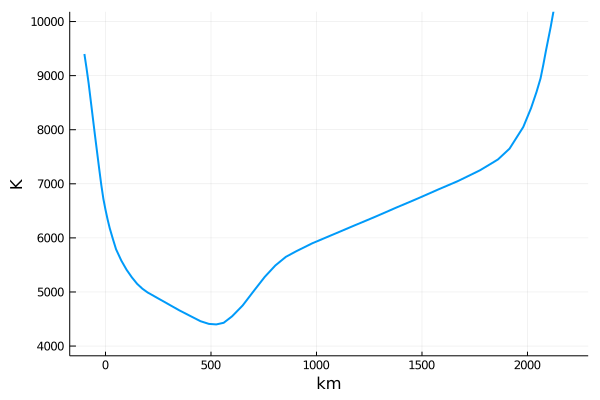

In [11]:
plot(falc.height .|> u"km", falc.temperature, w=2, ylim=[4e3, 1e4], legend=false)

### 1.2 Continuous Spectrum from the Solar Atmosphere

We now turn to the formation of the solar continuum radiation,
concentrating on the visible and near-infrared parts of its spectrum.

<img src="images/Subrahmanyan_Chandrasekhar.gif" width=200px>

*Subrahmanyan Chandrasekhar (1910-1995) is regarded by many as the greatest astronomer of the twentieth century. He also played an important role in the topic of this exercise, undertaking a very lengthy and difficult calculation (not a computation, no computers yet at that time!) of the bound-free and free-free extinction cross-sections of the H$^-$ ion, together with F.H. Breen. Their result, published in [Chandrasekhar & Breen (1946)](http://adsabs.harvard.edu/abs/1946ApJ...104..430C) will be duplicated in one of your graphs below. The shape of the extinction curve, 
with a peak near $\lambda =$ 1 μm and a minimum at the H$^-$ bound-free ionisation limit at $\lambda =$ 1.6 μm , reproduced the observed spectral variation of the unknown solar continuum extinction as derived already by G.F.W. Mulders at Utrecht in 1935 for $\lambda = $ 0.4- 2.5 μm. The brilliant suggestion that H$^-$ might cause this extinction, instead of the ensemble of unknown metal edges that was earlier postulated, had already been given by [Pannekoek (1930)](http://adsabs.harvard.edu/abs/1930MNRAS..91..139P), but was forgotten until it came independently from [Wildt (1939)](http://adsabs.harvard.edu/abs/1939ApJ....89..295W). The proof came with Chandrasekhar's laborious quantum mechanical evaluation and explained how the solar atmosphere can be opaque at gas densities much lower than the transparent air around us, as you found in the previous exercise. It revolutionised the understanding of cool-star atmospheres by much increasing their hydrogen-to-metals ratio and gas pressure compared with the earlier metallic-absorption modeling of Biermann, Uns&ouml;ld and Pannekoek himself. A more detailed description is found in [Hearnshaw (1986)](http://adsabs.harvard.edu/abs/1986asoh.book.....H). Photograph from Wikimedia commons.*


#### 1.2.1 Continuous Extinction


<img src="images/gray8-6a.svg" width=700px>

*Continuous extinction coefficients $\kappa_\nu^c$ for hydrogen and helium, per neutral hydrogen atom and per unit electron pressure, for the depth $\tau_0$ = 1 (continuum optical depth at $\lambda$ = 500 nm) in the photosphere of a solar-like dwarf star. The coefficients $\kappa$ are here measured per neutral hydrogen atom in whatever state of excitation, assuming Saha-Boltzmann population partitioning, and normalised by the electron pressure $P_\mathrm{e} = n_\mathrm{e} k \, T$. The cross-sections are in units of 10$^{-26}$cm$^2$ (not cm$^2$ as specified in the $y$-axis label); stimulated emission was not included in the computation of these curves. The H$^-$ curve shows the bound-free Balmer, Paschen and Brackett edges, plus part of the Pfund edge at right. The curves do not extend beyond the Balmer edge at left where the neglected metal edges become important. Thomson scattering is also neglected. From page 140 of [Gray (1992)](http://adsabs.harvard.edu/abs/1992oasp.book.....G).*

<img src="images/krijger-ion2.svg" width=400px>

*Ionisation edges for a selection of abundant elements. The triangular symbols depict bound-free continuum edges in the form of schematic hydrogenic $\nu^{-3}$ decay functions above each ionisation threshold. The plot shows the edge distribution over ionisation energy $\chi_{1c}$ (along the bottom) or threshold wavelength (along the top) and the logarithmic product of the element abundance $A_{12} \equiv \log (n_{\rm E}/n_{\rm H} +12)$ and the bound-free cross-section per particle at threshold $\sigma/\sigma_{\rm H}$ (vertically). Thus, it shows the relative importance of the major bound-free edges throughout the spectrum. They are all at ultraviolet wavelengths and do not contribute extinction in the visible and infrared. The plus signs indicate important first-ion edges; higher ionisation stages produce edges at yet shorter wavelengths. The abundance values come from [Engvold (1977)](http://adsabs.harvard.edu/abs/1977PhyS...16...48E), abundances the ionisation energies from [Novotny (1973)](http://adsabs.harvard.edu/abs/1973itsa.book.....N), the cross-sections from the chapter by [Baschek and Scholtz (1982)](http://adsabs.harvard.edu/abs/1982lbg6.conf.....A) This Krijger production following unpublished lecture notes by E.H. Avrett, taken from the [RTSA lecture notes](http://www.staff.science.uu.nl/~rutte101/Course_notes.html).*

We will assume that H$^-$(a hydrogen atom with an extra electron) is the major provider of continuous extinction in the solar atmosphere.  This is quite a good assumption
for the solar photosphere for wavelengths $\lambda > $ 0.5 μm. The second-best extinction provider are H I bound-free interactions, at only a few percent.  This may be seen in Figure above, taken from [Gray (1992)](http://adsabs.harvard.edu/abs/1992oasp.book.....G).

Below $\lambda =$ 500 nm there is heavy line crowding (not added in the figure from Gray) which acts as a quasi-continuum.  Below $\lambda =$ 365 nm the Balmer bound-free edge provides large extinction, and at yet shorter wavelengths the bound-free ionisaton edges of various metals (Al I, Mg I, Fe I, Si I, C I) provide steep extinction increase yet before the H I Lyman continuum sets in, as may be expected from the ionisation edges figure. In this exercise we will neglect these contributions by evaluating only the H$^-$ extinction and the extinction due to scattering off free electrons (Thomson scattering).

To calculate the H$^-$ continuous extinction we will follow the recipe of [Gray (1992)](http://adsabs.harvard.edu/abs/1992oasp.book.....G), coded in the function `compute_hminus_σ` below:

In [18]:
"""
Computes the H minus cross section, both free-free and
bound-free as per Gray (1992).

Parameters
----------
λ::Array{<:Unitful.Length, 1}
    Wavelength(s) to calculate in units of length.
temperature::Array{<:Unitful.Temperature}
    Gas temperature in units of K or equivalent.
electron_density::Array{<:Unitful.Length^-3}
    Electron density in units of per cubic length.

Returns
-------
σ::Array{<:Unitful.Area}
    Total H- cross section in si units. 
    Shape: shape of temperature + (nwave,)
"""
function compute_hminus_σ(
    λ::Array{<:Unitful.Length{T}, 1}, 
    temperature::Array{<:Unitful.Temperature{T}},
    electron_density::Array{<:NumberDensity{T}}
)::Array{<:Unitful.Area{T}} where T <: AbstractFloat
    
    # Reshape λ to allow broadcast with arrays of spatial position
    full_dims = ndims(temperature) + ndims(λ)
    λ = permutedims(repeat(λ, ones(Int, full_dims)...), full_dims:-1:1)
    θ = 5040.0u"K" ./ temperature
    electron_pressure = electron_density .* k_B .* temperature
    # Compute bound-free cross section for H-, following Gray 8.11-8.12
    σ_coeff = reverse([2.78701e-23, -1.39568e-18,  3.23992e-14, -4.40524e-10,
                       2.64243e-06, -1.18267e-05,  1.99654e+00])
    σ_bf = Polynomial(σ_coeff).(ustrip(λ .|> u"Å")) .* 1e-22u"m^2"
    # Set to zero above the H- ionisation limit at 1644.4 nm
    σ_bf[λ .> 1644.2u"nm"] .= 0.0u"m^2"
    # convert into bound-free per neutral H atom assuming Saha,  Gray p156
    k_const = 4.158E-10u"cm^2 / dyn"
    gray_saha = k_const .* electron_pressure .* (θ .^ 2.5 .* 10 .^ (0.754 .* θ))
    kappa_bf = σ_bf .* gray_saha   # per neutral H atom
    kappa_bf .*= (1. .- exp.((-h * c_0) ./ (λ .* k_B .* temperature)))
    
    # Now compute free-free opacity, following Gray 8.13
    # coefficients for 4th degree polynomials in the log of wavelength (in Å)
    coeffs = [[-0.0533464, 0.76661, -1.685,   -2.2763],
              [-0.142631,  1.99381, -9.2846,  15.2827],
              [-0.625151, 10.6913, -67.9775, 190.266, -197.789]]
    logλ = log10.(ustrip(λ .|> u"Å"))
    logθ = log10.(θ)
    tmp = zeros(Float64, size(kappa_bf))
    tmp += Polynomial(reverse(coeffs[3])).(logλ) .* logθ .* logθ
    tmp += Polynomial(reverse(coeffs[2])).(logλ) .* logθ
    tmp += Polynomial(reverse(coeffs[1])).(logλ) .* ones(Float64, size(kappa_bf))
    kappa_ff = electron_pressure .* 10 .^ tmp
    kappa_ff = kappa_ff .* 1e-26u"cm^4 / dyn"
    return (kappa_bf .+ kappa_ff) .|> u"m^2"
end

compute_hminus_σ

#### 1.2.2 Optical Depth

Knowing the model atmosphere and the continuous extinction coefficient as function of height, we may now compute the corresponding optical depth scale given by:

\begin{equation}
  \tau_\lambda(h_0) 
  \equiv -\int_\infty^{h_0} \alpha_\lambda^c \rm{d} h
              \label{eq:tau_cont}
\end{equation}

at any height $h_0$.  Note that both FALC and the 3D model are tabulated in reverse order,
corresponding to the $-h$ direction. For the $\tau$ integration in Julia, the recommended approach is trapezoidal integration. In this particular case, we want a value of $\tau$ for each height point, so for every point we integrate $\alpha_\lambda$ *up to that point*, and not across the whole range of heights. This is called a *cumulative* integration. Fortunately, `NumericalIntegration.jl` has a function `cumul_integrate` that does this, so it is possible to calculate $\tau$ with a single call.

#### 1.2.3 Emergent intensity and height of formation

We are now ready to compute the intensity of the radiation 
that emerges from the centre of the solar disk 
(in the radial direction from the solar sphere).
It is given (assuming plane-parallel stratification) by:

\begin{equation}
  I_\lambda = \int_0^\infty S_\lambda e^{-\tau_\lambda}
              \rm{d} \tau_\lambda.
\end{equation}

The integrand tells us how much radiation is coming from a given layer, also called the contribution function to intensity:

\begin{equation}
  \frac{\rm{d} I_\lambda}{\rm{d} h} =  
      S_\lambda e^{-\tau_\lambda} \alpha_\lambda
\end{equation}

which shows the contribution of each layer to the emergent intensity.
Its weighted mean defines the "mean height of formation":

\begin{equation}
  <\!h\!> \, \equiv \,
       \frac{\int_0^\infty h \, (\rm{d} I_\lambda/\rm{d} h) \rm{d} h}
                      {\int_0^\infty (\rm{d} I_\lambda/\rm{d} h) \rm{d} h}
     = \frac{\int_0^\infty h \, S_\lambda e^{-\tau_\lambda}
                \rm{d} \tau_\lambda}
            {\int_0^\infty S_\lambda e^{-\tau_\lambda}
              \rm{d} \tau_\lambda}.
  \label{eq:meanh}
\end{equation}

#### 1.2.4 Intensity from different directions and flux

The solar disk-centre intensity can be calculated by using the integral expression for $S_\lambda \mathrm{e}^{-\tau_\lambda}$, which you can integrate with `integrate` from `NumericalIntegration.jl`. For the general case with different inclinations (given by $\mu=\cos\theta$) in a 1D plane-parallel atmosphere, the emergent intensity is given by

\begin{equation}
    I_\lambda(0, \mu) = \int_0^\infty S_\lambda \mathrm{e}^{-\tau_\lambda/\mu}d\tau_\lambda/\mu.
    \label{eq:ilambda}
\end{equation}

We transform $\tau_\lambda \to \tau_\lambda/\mu$, meaning that inclined rays go through more material to reach the same depth in the z axis, and this increase in path length also increases the optical depth. This expression can be used to compute the intensity for any inclination (in the 1D case), we can use it to calculate the flux $\cal{F}_\lambda$:

\begin{equation}
    \mathcal{F}_\lambda = \int I_\lambda \mathrm{d}\Omega  = 2\pi\int_{-1}^1\mu I_\lambda \mathrm{d}\mu
\end{equation}

Note that in the lecture notes the flux $\mathcal{F}_\lambda = \pi F_\lambda$, is called "flux", while $F_\lambda$ is called the "astrophysical flux". They differ only by a factor of $\pi$ for a spherical radiator. In this assignment we will only use the astrophysical flux (when we refer, for simplicity, as "flux"). For a spherical emitter, and getting only the emergent (outgoing) flux, we have:

\begin{equation}
    F^+_\lambda = 2\int_0^1\mu I_\lambda(0, \mu)\, \mathrm{d}\mu
\end{equation}

Equation (\ref{eq:ilambda}) can be used evaluate $I_\lambda(0, \mu)$, but it cannot be evaluated at $\mu=$0. The naive way to get $F$ is simply to integrate $I_\lambda(0,\mu)$ trapezoidally over a range of angles, e.g. $\mu =$ 0.1, 0.2, ..., 1.0, but that
produces too much flux, even while ignoring the small contribution from the outer limb ($\mu=$ 0.0-0.1, $\sin\theta =$ 0.995-1), because $I_\lambda(0,\mu) \, \mu$ is a concave function ill-fitted with straight segments. This integral is therefore better evaluated with "open quadrature", an integration formula neglecting the endpoints. Classical equal-spacing recipes are the Open Newton-Cotes quadrature formulae but it is much better to use non-equidistant [Gaussian quadrature](https://en.wikipedia.org/wiki/Gaussian_quadrature), that approximate:

\begin{equation*}
    \int_{-1}^1 f(x)\, \mathrm{d}x \approx \sum_{i=1}^{n}w_i f(x_i).
\end{equation*}

In our case, $n$ is the number of rays (or directions) that we will compute $I_\lambda(0,\mu)$ for. The points $x_i$ and the weights $w_i$ are defined in the Gaussian quadrature. The last thing to note is that $x_i$ and $w_i$ are defined for an integral from $-$1 to 1, but we want from 0 to 1. So we must modify them accordingly:

\begin{eqnarray*}
    x'_i  & = &  \frac{x_i}{2} +\frac{1}{2}\\
    w'_i & = & \frac{w_i}{2} 
\end{eqnarray*}

To calculate the astrophysical flux, a Gaussian quadrature with three rays ($n=$3) is a reasonable choice). You can use the following values:

In [17]:
# Three-point Gaussian integration intensity -> flux
# rescale mu range from [-1, 1] to [0, 1]
μ_gauss = [-0.7745966692 0.0 0.7745966692] ./ 2 .+ 0.5 
weight_gauss = [0.5555555555 0.8888888888 0.5555555555] / 2;

---

### Exercise 1: The FALC Model

Use the FALC model from `falc.dat`, loaded above.

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
    
* Plot the total pressure $p_{\rm total}$ against the column mass $m$, both linearly and logarithmically.  You will find that they scale linearly.  Explain what assumption has caused $p_{\rm total} = c\,m$ and determine the value of the solar surface gravity $g_{\rm surface} = c$ that went into the FALC-producing code.

* [Fontenla et al. (1993)](http://adsabs.harvard.edu/abs/1993ApJ...406..319F) also assumed complete mixing, *i.e.* the same elements mix at all heights. Check this by plotting the ratio of the hydrogen mass density to the total mass density against height. Then add helium to hydrogen using their abundance and mass ratios ($N_{\rm He}/N_{\rm H} = 0.1$, $m_{\rm He} = 3.97 \, m_{\rm H}$), and estimate the fraction of the total mass density made up by the remaining elements in the model mix (the "metals").

* Create a plot of the gas pressure against height, and then overplot the product $(n_{\rm H} + n_{\rm e}) \, k_B T$. Plot the ratio of the two curves to show their differences.  Do the differences measure deviations from the ideal gas law or something else? Now add the helium density $n_{\rm He}$ to the product and enlarge the deviations. Do you see a pattern emerging? Comment on what could be missing between your calculations and the gas pressure from the model.

* Plot the ionisation fraction of hydrogen logarithmically against height. Why does this curve look like the temperature stratification plotted earlier? And why is it tilted with respect to that?

* Let us now compare the photon and particle densities. In thermodynamic equilibrium (TE) the radiation is isotropic with intensity $I_\nu = B_\nu$ and has total energy density (Stefan Boltzmann)
    \begin{equation*}
         u = \frac{1}{c} \int\!\!\!\int B_\nu \mathrm{d}\Omega \mathrm{d}\nu
           = \frac{4\sigma}{c} T^4,
      \end{equation*} so that the total photon density for isotropic TE radiation is given, with $u_\nu = \rm{d} u/\rm{d} \nu$, $T$ in K and $N_{\rm phot}$ in photons per m$^3$, by  
    \begin{equation*}
         N_{\rm phot} = \int_0^\infty \frac{u_\nu}{h\nu} \mathrm{d} \nu
            \approx 60.42\,\left(\frac{k_B T}{hc}\right)^3.
         \label{eq:20T3}
      \end{equation*} 
    This equation gives a reasonable estimate for the photon density at the deepest model location. Compute the value there and compare it to the hydrogen density. Conjecture why this equation is not valid higher up in the atmosphere. 
      
* In the upper atmosphere, the photon density there is given by
$$
N_{\rm phot} \approx \frac{60.42}{2\pi}\,\left(\frac{k_B T_{\rm eff}}{hc}\right)^3,
$$
with $T_{\rm eff} = 5777$ K the effective solar temperature (since $\pi B(T_{\rm eff}) = \sigma T_{\rm eff}^3 = {\cal F^+} = \pi \overline{I^+}$ with ${\cal F^+}$ the emergent flux and $\overline{I^+}$ the disk-averaged emergent intensity). Compare it to the hydrogen density at the highest location in the FALC model. The medium there is insensitive to these photons (except those at the centre wavelength of the hydrogen Ly $\alpha$ line), why?
    
</div>

### Exercise 2: Observed Solar Continua


The file `solspect.dat` specifies the continuum radiation emitted by the sun in the wavelength range $\lambda =$ 0.2-5 μm, taken from [Allen (1976)](http://adsabs.harvard.edu/abs/1976asqu.book.....A). The data in the file are organised in five columns:

| Wavelength  | Flux (smoothed)  | Flux (continuum) | Intensity (smoothed) | Intensity (continuum)  |
| ------------- |-------------|------|------|-------------|

The units of wavelength are μm, while all the other quantities are in $10^{10}$ erg s$^{-1}$ cm$^{-2}$ μm$^{-1}$ sr$^{-1}$. "Smoothed" here means in the wavelength dimension, so that the spectral lines are not visible. The continuum versions are an attempt at measuring the true emission if there were no spectral lines. 



<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
    
* Plot the four spectral distributions together in one figure over the range $\lambda =$ 0-2 μm. Check that the continuum intensity (`i_cont`) reaches $I_\lambda^c =$ 46 kW m$^{-2}$ nm$^{-1}$ sr$^{-1}$  at $\lambda =$ 0.41 μm. Explain why the four distributions share the same units and discuss the differences between them.

* Convert these spectral distributions into values per frequency bandwidth $\Delta \nu =$ 1 Hz. Plot these also against wavelength. Check: peak $I_\nu^c =$ 42.1 nW m$^{-2}$ Hz$^{-1}$ sr$^{-1}$  at $\lambda =$ 0.80 μm.

* Try to fit a Planck function to the solar continuum intensity. What rough temperature estimate do you get?

* Invert the Planck function analytically to obtain an equation which converts an intensity distribution $I_\lambda$ into brightness temperature $T_b$ (defined by $B_\lambda(T_b) \equiv I_\lambda$). Code it as a function and use that to plot the brightness temperature of the solar continuum against wavelength. Discuss the shape of this curve. It peaks near $\lambda =$ 1.6 μm. What does that mean for the radiation escape at this wavelength?
</div>

### Exercise 3: Continuous Extinction

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">

* Using the function `compute_hminus_σ`, compute and plot the H$^-$ extinction for wavelengths between 300-1000 nm, and for the temperature and density at the solar surface (height = 0) in the FALC model.
    
* Hydrogenic bound-free edges behave just as H$^-$ with maximum extinction at the ionisation limit and decay $\sim \lambda^3$ for smaller wavelengths, as indeed shown by the H$^-$ curve. The H$^-$ bound-free extinction differs strongly from this pattern. Why is it not hydrogenic although due to hydrogen?

* How should you plot this variation to make it look like the solar brightness temperature variation with wavelength? Why?

* Compute and plot the H$^-$ extinction as a function of height for the FALC model, at $\lambda =$ 0.5 μm. This plot needs to be logarithmic in y, why?

* Now add the Thomson scattering off free electrons to the extinction per m. The Thomson cross-section per electron is the same at all wavelengths and is given by       
\begin{equation*}
        \sigma^{\rm T} = 6.652 \times 10^{-29} \rm{m}^2.
\end{equation*} 
By which height-dependent quantity do you have to multiply this number to obtain extinction per m? Overplot this contribution to the continuous extinction $\alpha_\lambda^c(h)$ in your graph and then overplot the total continuous extinction too.  Note where which effect dominates.
    
</div>


### Exercise 4: Optical Depth and Height of Formation

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
    
* Similar to what you've done in Exercise 3, compute the H$^-$ extinction as a function of height for the FALC model at at $\lambda =$ 0.5 μm. Now use it to compute the optical depth as function of height, $\tau_{500}$. Plot this against the $\tau_{500}$ from the FALC model (saved in `falc.tau_500`). You will see there is a mismatch, explain why. (Hint: recompute $\tau_{500}$ by adding also extinction from Thomson scattering.)

* Using the continuous extinction you computed above (from H$^-$ and Thomson scattering), use equation (4) to compute $<\!h\!>$, the  mean height of formation at 500 nm. What is the meaning of this value?
    
* Compute and plot the contribution function from equation (3) for 500 nm and compare with $<\!h\!>$ (plot it as a vertical line in the same figure). Discuss the shape of the curve and its meaning.
    
* Repeat the above normalised contribution plot for $\lambda =$ 1 μm, $\lambda =$ 1.6 μm, and $\lambda =$ 5 μm (all in same plot). Discuss the changes of the contribution functions and their cause.
</div>